In [0]:
import math
import random

random.seed(250)


class Connection:
    def __init__(self, weight):
        self.weight = weight
        self.delta_weight = 0.0


class Neuron:
    # Class constants
    eta = 0.15  # Overall net learning rate [0.0, 1.0]
    alpha = 0.5  # Multiplier of last weight change, momentum [0.0, 1.0]

    def __init__(self, my_idx, num_outputs):
        """Constructor for Neuron
        :param num_outputs: The number of out-links this neuron has
        """
        self.output_val = 1.0
        self.my_idx = my_idx
        self.gradient = 0.0
        # Each element in output weights is a Connection object
        self.output_weights = list()
        for i in range(num_outputs):
            self.output_weights.append(Connection(self.random_weight()))

    @staticmethod
    def random_weight():
        return random.random()

    @staticmethod
    def transfer_function(weighted_sum):
        """Performs activation function on the weighted_sum
        :param weighted_sum: The weighted sum from the previous layer
        :return: Transformed weighted sum
        """
        # Performing tanh on the weighted sum. Range (-1.0, 1.0)
        return math.tanh(weighted_sum)

    @staticmethod
    def transfer_function_derivative(weighted_sum):
        """Performs derivative of activation function on the weighted_sum
        :param weighted_sum: The weighted sum from the previous layer
        :return: Transformed weighted sum
        """
        # derivative of tanh(x) is (1 - x^2)
        return 1.0 - (weighted_sum ** 2)

    def feed_forward(self, prev_layer):
        """Performs forward propagation by computing output value of a neuron
        :param prev_layer: List of previous layer neurons
        """
        weighted_sum = 0.0

        for prev_neuron in prev_layer:
            weighted_sum += prev_neuron.output_val * prev_neuron.output_weights[self.my_idx].weight

        self.output_val = self.transfer_function(weighted_sum)

    def calc_output_gradient(self, target_val):
        """Computes the target values for the output neuron
        :param target_val:
        :return:
        """
        delta = target_val - self.output_val
        self.gradient = delta * self.transfer_function_derivative(self.output_val)

    def sum_dow(self, next_layer):
        """
        :param next_layer:
        :return:
        """
        dow_sum = 0.0
        # Sum our contributions of the errors at the nodes we feed
        for neuron_idx in range(len(next_layer) - 1):
            dow_sum += (self.output_weights[neuron_idx].weight * next_layer[neuron_idx].gradient)
        return dow_sum

    def calc_hidden_gradient(self, next_layer):
        """
        :param next_layer:
        :return:
        """
        dow = self.sum_dow(next_layer)
        self.gradient = dow * self.transfer_function_derivative(self.output_val)

    def update_input_weights(self, prev_layer):
        """This method is called after back propagation to update the input weights
        :param prev_layer: List of previous layer neurons
        """
        # The weights to be updated are in the connection container
        # in the neurons in the preceding layer
        for neuron in prev_layer:
            old_delta_weight = neuron.output_weights[self.my_idx].delta_weight
            new_delta_weight = (neuron.eta * neuron.output_val * self.gradient) + (neuron.alpha * old_delta_weight)
            neuron.output_weights[self.my_idx].delta_weight = new_delta_weight
            neuron.output_weights[self.my_idx].weight += new_delta_weight

    def __str__(self):
        """Returns the string representation of the object for printing
        :return: The string representation of the object
        """
        ret_str = 'My index:' + str(self.my_idx) + '\nOutput weights:'
        for conn in self.output_weights:
            ret_str += str(conn.weight) + ' '
        return ret_str


class Net:
    def __init__(self, topology):
        """Constructor to create a neural net
        :param topology: List that contains the number of neurons in each layer
        """
        # Represent the layers in the neural net
        self.layers = list()

        # Each layer contains a list of neurons
        for layer_num, neuron_count in enumerate(topology):
            neuron_list = list()
            num_outputs = 0 if layer_num == len(topology) - 1 else topology[layer_num + 1]
            for index in range(neuron_count + 1):
                neuron_list.append(Neuron(index, num_outputs))
            self.layers.append(neuron_list)

        self.error = 0.0

    def feed_forward(self, input_vals):
        """Performs forward propagation in the network
        :param input_vals: List of input parameters
        """
        assert len(input_vals) == len(self.layers[0]) - 1

        # Assigning input values to the input neurons
        for index in range(len(input_vals)):
            self.layers[0][index].output_val = input_vals[index]

        # Forward propagation
        for index in range(1, len(self.layers)):
            prev_layer = self.layers[index - 1]
            for neuron_idx in range(len(self.layers[index]) - 1):
                self.layers[index][neuron_idx].feed_forward(prev_layer)

    def back_prop(self, target_vals):
        """Performs back propagation in the network
        :param target_vals: List of output values
        :return:
        """
        # Calculate overall net error (RMS of output neuron errors)
        output_layer = self.layers[len(self.layers) - 1]
        error = 0.0

        for neuron_idx in range(len(target_vals)):
            delta = target_vals[neuron_idx] - output_layer[neuron_idx].output_val
            error += (delta ** 2)

        error /= (len(target_vals))  # Average error squared
        self.error = math.sqrt(error)  # RMS

        # Calculate output layer gradients
        for neuron_idx in range(0, len(output_layer) - 1):
            output_layer[neuron_idx].calc_output_gradient(target_vals[neuron_idx])

        # Calculate gradients on hidden layers
        for layer_idx in range(len(self.layers) - 2, 0, -1):
            hidden_layer = self.layers[layer_idx]
            next_layer = self.layers[layer_idx + 1]

            for hidden_neuron in hidden_layer:
                hidden_neuron.calc_hidden_gradient(next_layer)

        # For all layers from output to first hidden layer,
        # update connection weights
        for layer_idx in range(len(self.layers) - 1, 0, -1):
            curr_layer = self.layers[layer_idx]
            prev_layer = self.layers[layer_idx - 1]

            for neuron_idx in range(0, len(curr_layer) - 1):
                neuron = curr_layer[neuron_idx]
                neuron.update_input_weights(prev_layer)

    def get_results(self):
        """Returns the results
        :return: An array of predicted output
        """
        results = list()
        output_layer = self.layers[len(self.layers) - 1]
        for idx in range(0, len(output_layer) - 1):
            results.append(output_layer[idx].output_val)
        return results


def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model


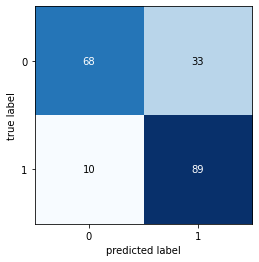